In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils, plot_help

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score, precision_recall_curve
from joblib import dump, load

import xgboost as xgb



%matplotlib inline

In [2]:
#change read limit to -1 to load entire dataframe
df_bus = utils.chunk_loader('data/cleaned/business_merge_feats.csv', read_limit=100_000)

#make dataframe of numeric types
df_bus_numeric = df_bus.select_dtypes(include=[np.float64, np.int64]).copy()
print(df_bus_numeric.shape)

X_train, X_test, y_train, y_test = utils.train_test_scale(df_bus_numeric, 
                                                           'is_open', 
                                                           random_state=None)

(100000, 104)


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [3]:
xgb_model = xgb.XGBClassifier(n_estimators=300,subsample=0.9, n_jobs=-1)

xgb_grid = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    }

clf = GridSearchCV(xgb_model, xgb_grid, n_jobs=-1, cv=5, verbose=10, scoring='roc_auc')

#fit to training data
clf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 61.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 1207.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 1231.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 1264.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 1291.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 1309.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 1324.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 1353.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 1379.8min
[Parallel(n_jobs=-1)]: Done 173 tasks   

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'num_boost_round': [100, 250, 500], 'eta': [0.05, 0.1, 0.3], 'max_depth': [6, 9, 12], 'subsample': [0.9, 1.0], 'colsample_bytree': [0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [8]:
print(clf.best_params_ )

print(clf.best_score_)

{'colsample_bytree': 0.9, 'eta': 0.05, 'max_depth': 6, 'num_boost_round': 100, 'subsample': 0.9}
0.8238012723980093


In [7]:
#save the work
dump(clf, 'classifiers/xgb_cv.joblib') 

['classifiers/xgb_cv.joblib']

              precision    recall  f1-score   support

           0       0.74      0.36      0.48      3767
           1       0.87      0.97      0.92     16233

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.81      0.66      0.70     20000
weighted avg       0.84      0.86      0.83     20000

----------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


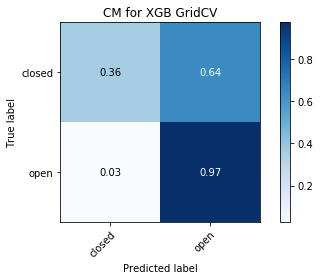

----------


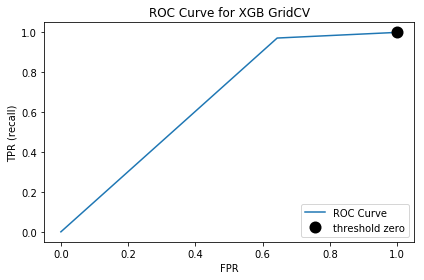

Area Under Curve = 0.6643
----------


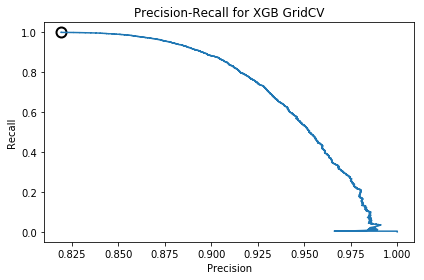

In [9]:
#make pred
y_xgb = clf.predict(X_test)

print(classification_report(y_test, y_xgb))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, y_xgb, ['closed', 'open'], normalize=True,
                                title='XGB GridCV')
print(10*'-')
plot_help.plot_roc_curve(y_test, y_xgb, 'XGB GridCV')
print(10*'-')
plot_help.plot_prc_curve(y_test, clf.predict_proba(X_test)[:, 1], 'XGB GridCV')